# Training a CNN on CIFAR-100 with PyTorch



In [ ]:
#pytorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms  as transforms

#matrice et graphiques
import matplotlib.pyplot as plt
import numpy as np

#Device used
device=torch.device("cuda" if torch.cuda.is_available else "cpu")
print(device)

cuda


# Download CIFAR-100 and Create Dataloaders
We’ll load the CIFAR-100 dataset via torchvision.datasets. The dataset is automatically downloaded. We’ll apply typical data augmentation and normalization.

In [ ]:
# CIFAR-100 stats (mean & std) from https://github.com/weiaicunzai/pytorch-cifar100/blob/master/conf/global_settings.py
mean = (0.5071, 0.4867, 0.4408)
std  = (0.2675, 0.2565, 0.2761) # 3 valeurs car 3 channels (images RGB)

#data augmentation
train_transforms = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

#datasets
train_datasets= torchvision.datasets.CIFAR100(
    root="./data",
    train = True,
    transform = train_transforms,
    download= True
)

test_datasets= torchvision.datasets.CIFAR100(
    root="./data",
    train = False,
    transform = test_transforms,
    download= True
)

#dataloader
batch_size=10
train_dataloader = torch.utils.data.DataLoader(
    train_datasets,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

test_dataloader = torch.utils.data.DataLoader(
    test_datasets,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

print(dir(test_datasets))
print("Dataset labels :", test_datasets.classes)
print(train_datasets)

Files already downloaded and verified
Files already downloaded and verified
['__add__', '__annotations__', '__class__', '__class_getitem__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__orig_bases__', '__parameters__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_check_integrity', '_format_transform_repr', '_is_protocol', '_load_meta', '_repr_indent', 'base_folder', 'class_to_idx', 'classes', 'data', 'download', 'extra_repr', 'filename', 'meta', 'root', 'target_transform', 'targets', 'test_list', 'tgz_md5', 'train', 'train_list', 'transform', 'transforms', 'url']
Dataset labels : ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy',

# Define a Simple CNN Model
Here is a small convolutional network. In practice, you could try a deeper architecture, or a pretrained model. This is just an example.

In [ ]:
class SimpleCNN(nn.Module) :
    def __init__(self,num_classes=100) :
        super(SimpleCNN,self).__init__()
        self.features=nn.Sequential(
            nn.Conv2d(3,32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True), # ne pas oublier la AF après la BN ni le inplace dans reLU
            nn.MaxPool2d(2),

            nn.Conv2d(32,64, kernel_size=3, padding=1), #ne pas oublier le kernel size
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2), #8x8

            nn.Conv2d(64,128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2) # 4x4
        )

        self.classifier=nn.Sequential(
            nn.Flatten(),
            nn.Linear(4*4*128,256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256,num_classes)
        )

    def forward(self, x) : #variable self toujours en premier dans classe
        x=self.features(x)
        x=self.classifier(x)
        return x

model=SimpleCNN(num_classes=100).to(device) #le model doit TOUJOURS être rattaché à notre GPU
print(model)

SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2048, out_features=256, bias=T

# Training & Validation Utilities

In [ ]:
def training_one_epoch(model,dataloader,criterion,optimizer,device) : #ne pas oublier de déclarer le model
    running_loss=0.0
    correct=0
    total=0

    for images,labels in dataloader :
        images,labels= images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs=model(images)
        loss=criterion(outputs,labels) #une loss se fait par rapport AUX LABELS
        loss.backward()
        optimizer.step()

        running_loss+=loss.item() * images.size(0)
        correct+=(torch.argmax(outputs,1)== labels).sum().item() # c'est l'indice du max DE OUTPUTS (aucun rapport avec la loss)
        total+= labels.size(0) # ==labels, les indices sont des labels

    epoch_loss=running_loss/total
    epoch_acc= correct/total
    return epoch_loss, epoch_acc


def validate(model,dataloader,criterion,device) : #ne pas oublier de déclarer le model
    running_loss=0.0
    correct=0
    total=0

    with torch.no_grad() :
        for images,labels in dataloader :
            images,labels= images.to(device), labels.to(device)
            outputs=model(images)
            loss=criterion(outputs,labels)

            running_loss+=loss.item() * images.size(0)
            correct+=(torch.argmax(outputs,1)== labels).sum().item() # ==labels, les indices sont des labels
            total+= labels.size(0)

    epoch_loss=running_loss/total
    epoch_acc= correct/total
    return epoch_loss, epoch_acc


# Train the Model

In [ ]:
class ScaledCrossEntropyLoss(nn.Module) :
    def __init__(self,temperature) : # le constructeur est une fonction
        super(ScaledCrossEntropyLoss,self).__init__()
        self.temperature=temperature

    def forward(logits, labels, self) :
        scaled_logits=logits/self.temperature

        ScaledCrossEntropyloss=F.cross_entropy(scaled_logits, labels)

        return ScaledCrossEntropyloss


In [ ]:
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(), lr=0.001)

nb_epochs=10
train_losses, train_accs = [], []
test_losses, test_accs = [], []

for num_epoch in range(0,nb_epochs) :
    train_loss, train_acc = training_one_epoch(model, train_dataloader, criterion, optimizer, device)
    test_loss, test_acc = validate(model, train_dataloader, criterion, device)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)

    print(f"Epoch {num_epoch+1}/{nb_epochs}")
    print(f"  training loss : {train_loss:.4f}  training accuracy : {train_acc*100:.2f}")
    print(f"  test loss : {test_loss:.4f}  test accuracy : {test_acc*100:.2f}")

Epoch 1/10
  training loss : 3.8074  training accuracy : 10.47
  test loss : 3.7176  test accuracy : 12.15
Epoch 2/10
  training loss : 3.6667  training accuracy : 12.94
  test loss : 3.5860  test accuracy : 14.35
Epoch 3/10
  training loss : 3.5630  training accuracy : 14.71
  test loss : 3.5010  test accuracy : 15.47
Epoch 4/10
  training loss : 3.4912  training accuracy : 16.05
  test loss : 3.4400  test accuracy : 16.99
Epoch 5/10
  training loss : 3.4111  training accuracy : 17.47
  test loss : 3.3815  test accuracy : 17.64
Epoch 6/10
  training loss : 3.3518  training accuracy : 18.25
  test loss : 3.3261  test accuracy : 18.87
Epoch 7/10
  training loss : 3.2830  training accuracy : 19.48
  test loss : 3.2140  test accuracy : 20.72
Epoch 8/10
  training loss : 3.2226  training accuracy : 20.97
  test loss : 3.1976  test accuracy : 21.16
Epoch 9/10
  training loss : 3.1602  training accuracy : 21.61
  test loss : 3.1253  test accuracy : 22.52
Epoch 10/10
  training loss : 3.1135 

# Visualize Training Curves

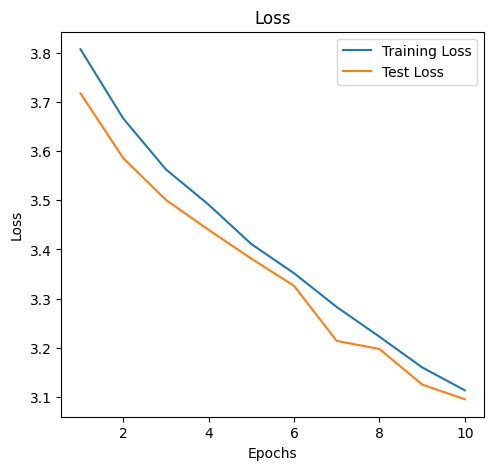

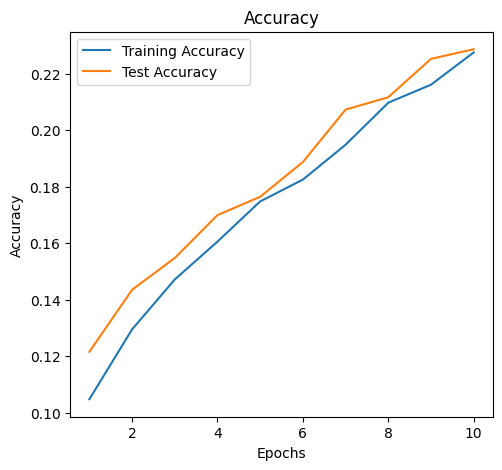

In [ ]:
epochs_range=range(1,nb_epochs+1)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs_range, train_losses, label="Training Loss")
plt.plot(epochs_range, test_losses, label="Test Loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs_range, train_accs, label="Training Accuracy")
plt.plot(epochs_range, test_accs, label="Test Accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

# Final Evaluation on Test Set

In [ ]:
test_loss, test_acc = validate(model, test_dataloader, criterion, device)
print("Final Evaluation")
print(f"  final test loss : {test_loss:.4f}  final test accuracy : {test_acc*100:.2f}")

Final Evaluation
  final test loss : 3.2034  final test accuracy : 22.01


# Define a ResNet model

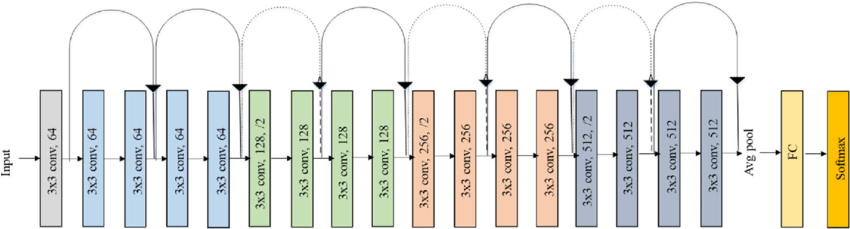

In [ ]:
class BasicBlock(nn.Module) :
    expansion=1

    def __init__(self, planes, inplanes, stride=1) :
        super(BasicBlock, self).__init__()
        self.conv1=nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias= False)
        self.bn1=nn.BatchNorm2d(planes)
        self.conv2=nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias= False)
        self.bn2=nn.BatchNorm2d(planes)

        #skipping path
        self.shortcut=nn.Sequential()
        if stride!=1 or planes!=inplanes :
            self.shortcut=nn.Sequential(
                nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias= False),
                nn.BatchNorm2d(planes)
            )

    def forward(self,x) :
        out=F.relu(self.bn1(self.conv1(x))) #on a affaire a des logits car pas de AF ci-dessus
        out=self.bn2(self.conv2(out))

        out+=self.shortcut(x)

        out=F.relu(out)
        return out

In [ ]:
class ResNet(nn.Module) :
    def __init__(self,block,num_blocks,num_classes=100) :
        super(ResNet,self).__init__()
        self.in_planes=64

        self.conv1=nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias= False)
        self.bn1=nn.BatchNorm2d(64)

        #each layer is a sequence of blocks
        self.layers1=self._make_layer(block, 64, num_blocks[0], 1)
        self.layers2=self._make_layer(block, 128, num_blocks[1], 2)
        self.layers3=self._make_layer(block, 256, num_blocks[2], 2)
        self.layers4=self._make_layer(block, 512, num_blocks[2], 2)

        #different skipping path
        self.shortcut1=nn.Sequential(nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias= False), nn.BatchNorm2d(128))
        self.shortcut2=nn.Sequential(nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias= False), nn.BatchNorm2d(256))
        self.shortcut3=nn.Sequential(nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1, bias= False), nn.BatchNorm2d(512))

        #final classification layer
        self.linear=nn.linear(512,num_classes)

    def _make_layer(self, block, planes, num_block, stride) :
        strides= [stride]+[1]*(num_block-1)
        layers = []
        for s in strides :
            layers.append(block(planes,self.in_planes,s))
            self.in_planes= planes*block.expansion
        return nn.Sequential(*layers) #plusieurs couches= nn.sequential

    def forward(self,x) :
        out=F.relu(self.bn1(self.conv1(x)))

        out1=out
        out=self.layers1(out)
        out+=out1

        out2=self.shortcut1(out)
        out=self.layers2(out)
        out+=out2

        out3=self.shortcut2(out)
        out=self.layers3(out)
        out+=out3

        out4=self.shortcut3(out)
        out=self.layers4(out)
        out+=out4

        #dernières couches
        out=F.avg_pool2d(out,4)
        out=out.view(out.size(0),-1)
        out=self.linear(out)
        return out

def ResNet18(num_classes=100) :
    return ResNet(BasicBlock,[2,2,2,2],num_classes)

model=ResNet18()
print(model)



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine